In [3]:
%pylab inline

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import tqdm
from __future__ import division

from sklearn.decomposition import PCA
import time
from sklearn.manifold import TSNE
from ggplot import *

Populating the interactive namespace from numpy and matplotlib


# Import data

In [4]:
# Read in Merged Data
df = pd.read_csv("/Users/ja/Documents/BigDataAnalytics/Project/AD_Challenge_Training_Data_Clinical_Updated_7.22.2014/Merged_clinbioimg_nona.csv")
df['DX.bl'] = df['DX.bl'].apply(lambda i: str(i))

In [ ]:
# Filter important features using results from Random Forest prediction
f_importance = pd.read_csv('/Users/ja/Documents/BigDataAnalytics/Project/AD_Challenge_Training_Data_Clinical_Updated_7.22.2014/feature_importance.csv')
selectfs = list(f_importance.Feature[f_importance.MeanDecreaseGini > 1.5])
f_importance.sort_values(by='MeanDecreaseGini',ascending=False)

# remove genetic features from list if analyzing merged clinical-imaging data
removelist = ['rs429358', 'rs7412','rs2075650', 'rs7561528', 'rs12808148', 'rs117383358']
for i in range(0,len(removelist)):
    selectfs.remove(removelist[i])

In [6]:
RID = df['RID']
y = df['DX.bl']
x = df.drop(['RID','DX.bl'],axis=1)
colnames = list(x.columns)

# filter by selected features
# x = x[selectfs]

In [7]:
y[y=='AD'] = "Alzheimer's"
y[y=='CN'] = "Normal Control"
y[y=='EMCI'] = "Early Mild Cognitive Impairement"
y[y=='LMCI'] = "Late Mild Cognitive Impairement"

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingW

## Normalization

In [8]:
x = x.as_matrix()
n_samples = x.shape[0]
x = x.astype(float)

In [9]:
# Normalize features to mean=0, variance = 1
x_mean = np.mean(x, axis = 0)
x_std = np.std(x, axis = 0)

d_x = np.subtract(x, np.matlib.repmat(x_mean, n_samples, 1) )
d_x = np.divide(x,np.matlib.repmat(x_std, n_samples, 1) )

In [10]:
df = pd.DataFrame(d_x,columns=colnames)
df['label'] = y
df['RID'] = RID
# df.to_csv('Normalized_ClinGeneImaging_NoNAs.csv',index=False)

## analysis

In [15]:
df = df.rename(columns={'DX.bl':'label'})
feat_cols = df.columns[0:df.shape[1]-2]
rndperm = np.random.permutation(df.shape[0])

# Check number of samples from each disease stage
df['label'].value_counts()

Normal Control                      101
Early Mild Cognitive Impairement     88
Late Mild Cognitive Impairement      51
Alzheimer's                          15
Name: label, dtype: int64

In [16]:
# PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print 'Explained variation per principal component: {}'.format(pca.explained_variance_ratio_)

Explained variation per principal component: [ 0.21511333  0.11127721  0.07658319]


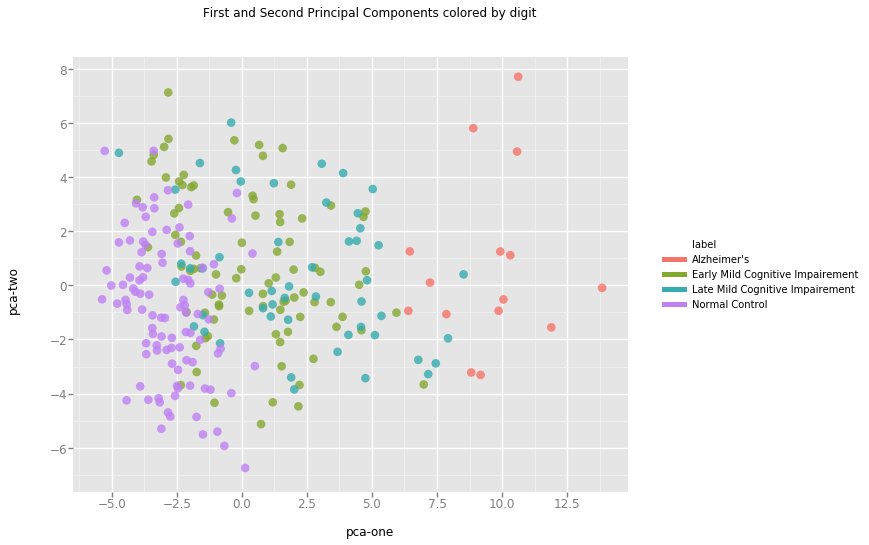

<ggplot: (7539358773)>

In [17]:
from ggplot import *

chart = ggplot( df.loc[rndperm[:3000],:], aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")
chart

In [18]:
# tSNE
n_sne = df.shape[0]
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=5000)
tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 255 samples in 0.001s...
[t-SNE] Computed neighbors for 255 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 255 / 255
[t-SNE] Mean sigma: 2.923416
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.627472
[t-SNE] Error after 1400 iterations: 0.819620


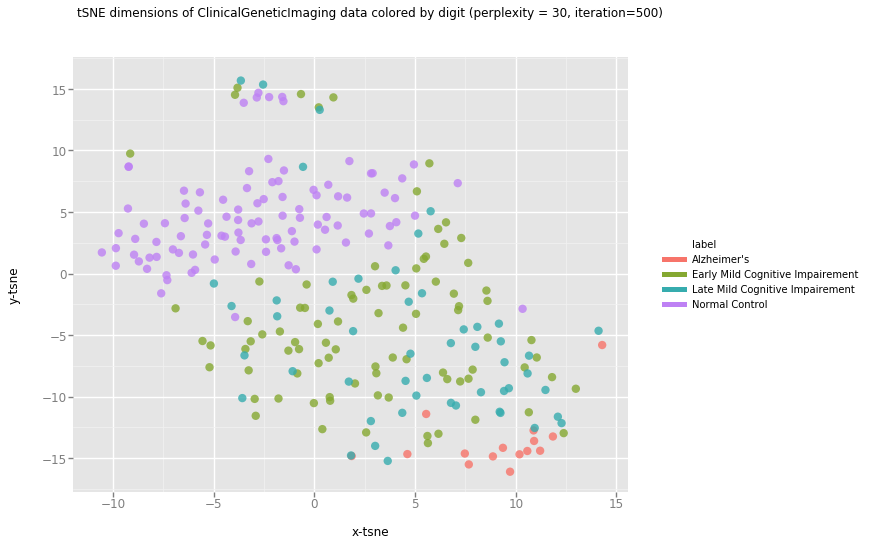

<ggplot: (7539825029)>

In [20]:
df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.8) \
        + ggtitle("tSNE dimensions of ClinicalGeneticImaging data colored by digit (perplexity = 30, iteration=500)")
chart